### Holiday Package Prediction using Random Forest Classification

In [38]:
import pandas as pd
from common_codes.utils import Utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score,roc_curve

from sklearn.model_selection import RandomizedSearchCV


In [2]:
df = pd.read_csv(Utils.get_file_path('Travel.csv'))
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


### Data Cleaning

In [3]:
df.isnull().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [4]:
## Check all the categorical features and check if it is balanced or not, either there is any misspealling or not etc.

df['Gender'].value_counts()

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [5]:
df['MaritalStatus'].value_counts()

MaritalStatus
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: count, dtype: int64

In [6]:
df['TypeofContact'].value_counts()

TypeofContact
Self Enquiry       3444
Company Invited    1419
Name: count, dtype: int64

In [7]:
df['Occupation'].value_counts()

Occupation
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: count, dtype: int64

In [8]:
df['ProductPitched'].value_counts()

ProductPitched
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: count, dtype: int64

In [9]:
df['Designation'].value_counts()

Designation
Executive         1842
Manager           1732
Senior Manager     742
AVP                342
VP                 230
Name: count, dtype: int64

In [10]:
## Fix the Gender and Maritial Status misspealling and correct it  

df['Gender']  = df['Gender'].replace('Fe Male', 'Female')
df['MaritalStatus'] = df['MaritalStatus'].replace('Single', 'Unmarried')

In [11]:
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Unmarried,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Unmarried,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [12]:
## Check the missing values
## these are the features with NaN values

features_with_na  = [features for features in df.columns if df[features].isnull().sum()>1] 
for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean()*100, 5), '% missing values')

Age 4.62357 % missing values
TypeofContact 0.51146 % missing values
DurationOfPitch 5.13502 % missing values
NumberOfFollowups 0.92062 % missing values
PreferredPropertyStar 0.53191 % missing values
NumberOfTrips 2.86416 % missing values
NumberOfChildrenVisiting 1.35025 % missing values
MonthlyIncome 4.76678 % missing values


### Imputing Null Values

1. Median value for Age
2. Mode for Type of Contract
3. Median for Duration of Pitch
4. Mode for Number of Followup and it is Discrete feature
5. Mode fore Preferred Property Star
6. Median for Number of trips
7. Mode for Number of children visiting
8. Median for Monthly Income


In [13]:
## Age
df.Age.fillna(df.Age.median(), inplace=True)

## Type of contract
df.TypeofContact.fillna(df.TypeofContact.mode()[0], inplace=True)

## Duration of pitch
df.DurationOfPitch.fillna(df.DurationOfPitch.median(), inplace=True)

## Number of followups
df.NumberOfFollowups.fillna(df.NumberOfFollowups.mode()[0], inplace=True)

## Preferred Property Star
df.PreferredPropertyStar.fillna(df.PreferredPropertyStar.mode()[0], inplace=True)

## Number of trips
df.NumberOfTrips.fillna(df.NumberOfTrips.median(), inplace=True)

## Number of children visited
df.NumberOfChildrenVisiting.fillna(df.NumberOfChildrenVisiting.mode()[0], inplace=True)

## Monthly income
df.MonthlyIncome.fillna(df.MonthlyIncome.median(), inplace=True)

/var/folders/07/8j6bcwpn5_qfb0_tjmt2qg100000gn/T/ipykernel_62632/2434172159.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Age.fillna(df.Age.median(), inplace=True)
/var/folders/07/8j6bcwpn5_qfb0_tjmt2qg100000gn/T/ipykernel_62632/2434172159.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [14]:
df.isnull().sum()

CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [15]:
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Unmarried,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Unmarried,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,36.0,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [16]:
## Drop customerID
df.drop('CustomerID', axis=1, inplace=True)

### Feture Engineering

#### Feture Extraction

In [17]:
# create new column for feature by combining two columns
df['TotalVisiting'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']
df.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True)

In [18]:
## get all the numeric features
## O means not equal to Object
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 12


In [19]:
##categorical features
## O means equal to Object
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 6


In [20]:
## Discrete features
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 9


In [21]:
## coontinuous features
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 3


In [22]:
df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalVisiting
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3.0,Deluxe,3.0,Unmarried,1.0,1,2,1,Manager,20993.0,3.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,Manager,20130.0,5.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,4.0,Basic,3.0,Unmarried,7.0,1,3,0,Executive,17090.0,3.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,3.0,Basic,3.0,Divorced,2.0,1,5,1,Executive,17909.0,3.0
4,0,36.0,Self Enquiry,1,8.0,Small Business,Male,3.0,Basic,4.0,Divorced,1.0,0,5,1,Executive,18468.0,2.0


### Train Test Split and Model Training

In [23]:
X = df.drop(['ProdTaken'], axis=1)
y = df['ProdTaken']

In [24]:
y.value_counts()

ProdTaken
0    3968
1     920
Name: count, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Transform the categorical features into some numerical values for the model

- We are also going to do the scaling down on the numerical features just to get all the features on same scale. For Random Forest and boosting algo we don't necessarily need it.

In [26]:
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(exclude=['object']).columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [27]:
preprocessor

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(drop='first'),
                                 Index(['TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
       'MaritalStatus', 'Designation'],
      dtype='object')),
                                ('StandardScaler', StandardScaler(),
                                 Index(['Age', 'CityTier', 'DurationOfPitch', 'NumberOfFollowups',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome', 'TotalVisiting'],
      dtype='object'))])

In [28]:
## Applying tranformation in training dataset always do fit_transform
X_train = preprocessor.fit_transform(X_train)


In [29]:
## Apply transformation in testing dataset always do transform. Because we want to avoid data leakage
X_test = preprocessor.transform(X_test)

In [32]:
## Random Forest Classifier Training

models = {
    
    "RandomForestClassifier": RandomForestClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) ## Train Model
    
    ## Make Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
     # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')



RandomForestClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9294
- F1 score: 0.9245
- Precision: 0.9552
- Recall: 0.6702
- Roc Auc Score: 0.8313




In [33]:
## Hyperparameter Training
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

In [34]:
rf_params

{'max_depth': [5, 8, 15, None, 10],
 'max_features': [5, 7, 'auto', 8],
 'min_samples_split': [2, 8, 15, 20],
 'n_estimators': [100, 200, 500, 1000]}

In [35]:
# Models list for Hyperparameter tuning
randomcv_models = [
                   ("RF", RandomForestClassifier(), rf_params)
                   
                   ]

In [36]:
randomcv_models

[('RF',
  RandomForestClassifier(),
  {'max_depth': [5, 8, 15, None, 10],
   'max_features': [5, 7, 'auto', 8],
   'min_samples_split': [2, 8, 15, 20],
   'n_estimators': [100, 200, 500, 1000]})]

In [37]:

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=None, max_features=auto, min_samples_split=20, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=20, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=20, n_estimators=200; total time=   0.0s
[CV] END max_depth=8, max_features=auto, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=8, max_features=auto, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=8, max_features=auto, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END max_depth=5, 

/Users/murtuzasaifee/Documents/Personal/Codes/python_ml_nlp/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/murtuzasaifee/Documents/Personal/Codes/python_ml_nlp/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/murtuzasaifee/Documents/Personal/Codes/python_ml_nlp/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/murtuzasaifee/Doc

---------------- Best Params for RF -------------------
{'n_estimators': 500, 'min_samples_split': 2, 'max_features': 8, 'max_depth': None}


In [39]:
## Training the model again based on best parameters

models={
    
    "Random Forest":RandomForestClassifier(n_estimators=500,min_samples_split=2,
                                          max_features=8,max_depth=None)
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9356
- F1 score: 0.9316
- Precision: 0.9571
- Recall: 0.7016
- Roc Auc Score: 0.8470




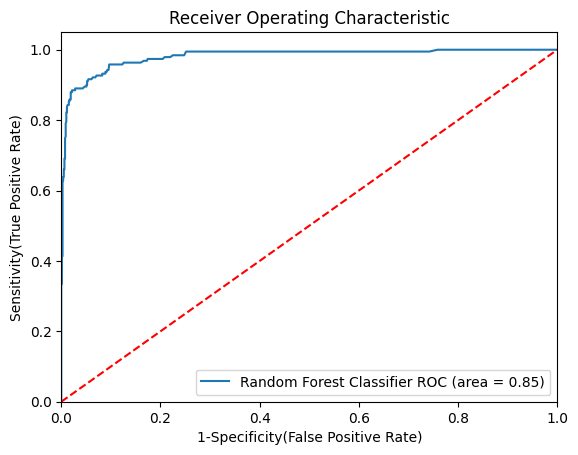

In [42]:
## Plot ROC AUC Curve

plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(n_estimators=500,min_samples_split=2,
                                          max_features=8,max_depth=None),
    'auc':  0.8470
},
    
]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("auc.png")
plt.show() 